# ============================================================
# 📘 NOTEBOOK 04: COUNTERFACTUAL EXPLANATIONS
# ============================================================
# 
# 🎯 Objetivo:
# Generar explicaciones contrafactuales para clientes rechazados
# "¿Qué debería cambiar este cliente para ser aprobado?"
#
# 📊 Contenido:
# 1. Carga del modelo y datos
# 2. Identificación de clientes rechazados
# 3. Generación de contrafactuales
# 4. Análisis de cambios mínimos
# 5. Recomendaciones accionables
# ============================================================

In [18]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("🚀 NOTEBOOK 04: COUNTERFACTUAL EXPLANATIONS")
print("="*60)
print("\n✅ Librerías cargadas correctamente")

🚀 NOTEBOOK 04: COUNTERFACTUAL EXPLANATIONS

✅ Librerías cargadas correctamente


In [19]:
# ============================================================
# 1. CARGA DEL MODELO Y DATOS
# ============================================================
print("\n" + "="*60)
print("📂 CARGA DE MODELO Y DATOS")
print("="*60)

# Cargar modelo entrenado
model = joblib.load('../models/xgboost_model.pkl')
print("✅ Modelo XGBoost cargado")

# Cargar encoders
label_encoders = joblib.load('../models/label_encoders.pkl')
print("✅ Label encoders cargados")

# Cargar datos
# Nombres de las columnas
column_names = [
    'checking_status', 'duration', 'credit_history', 'purpose', 
    'credit_amount', 'savings_status', 'employment', 'installment_rate',
    'personal_status', 'other_parties', 'residence_since', 
    'property_magnitude', 'age', 'other_payment_plans', 'housing',
    'existing_credits', 'job', 'num_dependents', 'own_telephone',
    'foreign_worker', 'risk'
]

# Cargar dataset
df = pd.read_csv('../../german_credit_data/german.data', 
                 sep=' ',
                 header=None,
                 names=column_names)
print(f"✅ Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")

# 🔍 VERIFICAR NOMBRE DE LA COLUMNA TARGET
print(f"\n🔍 Columnas del dataset:")
print(df.columns.tolist())

# Identificar columna target (puede ser 'Risk' o 'risk')
target_col = 'risk' if 'risk' in df.columns else 'Risk'
print(f"✅ Columna target identificada: '{target_col}'")

# Separar features y target
X = df.drop(target_col, axis=1)
y = df[target_col].map({'good': 0, 'bad': 1})

# Identificar tipos de variables (para saber cuáles son modificables)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 Features numéricas: {len(numeric_features)}")
print(f"📝 Features categóricas: {len(categorical_features)}")

# Aplicar encoding (igual que en entrenamiento)
X_encoded = X.copy()
for col in categorical_features:
    le = label_encoders[col]
    X_encoded[col] = le.transform(X[col])

print("✅ Encoding aplicado")


📂 CARGA DE MODELO Y DATOS
✅ Modelo XGBoost cargado
✅ Label encoders cargados
✅ Dataset cargado: 1000 registros, 21 columnas

🔍 Columnas del dataset:
['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_rate', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'risk']
✅ Columna target identificada: 'risk'

📊 Features numéricas: 7
📝 Features categóricas: 13
✅ Encoding aplicado


In [20]:
# ============================================================
# 2. IDENTIFICACIÓN DE CLIENTES RECHAZADOS
# ============================================================
print("\n" + "="*60)
print("🔍 IDENTIFICACIÓN DE CLIENTES RECHAZADOS")
print("="*60)

# Obtener predicciones para todo el dataset
y_pred = model.predict(X_encoded)
y_pred_proba = model.predict_proba(X_encoded)[:, 1]

# Identificar clientes REALMENTE rechazados (predicción = 1 = Bad Risk)
rejected_mask = y_pred == 1
rejected_indices = np.where(rejected_mask)[0]
rejected_proba = y_pred_proba[rejected_indices]

print(f"\n📊 Total de clientes rechazados: {len(rejected_indices)} ({len(rejected_indices)/len(df)*100:.1f}%)")
print(f"📊 Probabilidad promedio de Bad Risk: {rejected_proba.mean():.1%}")
print(f"📊 Rango de probabilidades: {rejected_proba.min():.1%} - {rejected_proba.max():.1%}")

# Seleccionar casos "recuperables" (55-75% Bad Risk)
# Estos tienen probabilidad alta pero no extrema
recoverable_mask = (rejected_proba >= 0.55) & (rejected_proba <= 0.75)
recoverable = rejected_indices[recoverable_mask]

print(f"\n💡 Clientes 'recuperables' (55-75% Bad Risk): {len(recoverable)}")

if len(recoverable) == 0:
    print("⚠️ No hay clientes en rango 55-75%, usando rechazados generales")
    # Tomar los 3 con menor probabilidad de los rechazados
    sorted_idx = np.argsort(rejected_proba)
    study_cases = rejected_indices[sorted_idx[:3]]
else:
    # Seleccionar 3 casos aleatorios de recuperables
    np.random.seed(42)  # Reproducibilidad
    study_cases = np.random.choice(recoverable, min(3, len(recoverable)), replace=False)

print(f"\n🎯 Casos de estudio seleccionados:")
for idx in study_cases:
    print(f"   Cliente #{idx}: {y_pred_proba[idx]:.1%} Bad Risk")


🔍 IDENTIFICACIÓN DE CLIENTES RECHAZADOS

📊 Total de clientes rechazados: 372 (37.2%)
📊 Probabilidad promedio de Bad Risk: 72.7%
📊 Rango de probabilidades: 50.1% - 96.3%

💡 Clientes 'recuperables' (55-75% Bad Risk): 149

🎯 Casos de estudio seleccionados:
   Cliente #460: 55.9% Bad Risk
   Cliente #133: 72.9% Bad Risk
   Cliente #761: 74.3% Bad Risk


In [21]:
# ============================================================
# 3. DEFINICIÓN DE FEATURES MODIFICABLES
# ============================================================
print("\n" + "="*60)
print("⚙️ CONFIGURACIÓN DE FEATURES MODIFICABLES")
print("="*60)

# Clasificar features según si son modificables o no
# En un escenario real, el cliente puede cambiar algunas cosas, pero no otras

modifiable_features = {
    # MODIFICABLES (el cliente puede cambiar):
    'savings_status': True,        # Puede aumentar ahorros
    'employment': True,            # Puede conseguir mejor empleo
    'other_payment_plans': True,   # Puede cancelar otros planes
    'property_magnitude': True,    # Puede adquirir propiedad
    'housing': True,               # Puede cambiar tipo de vivienda
    'job': True,                   # Puede cambiar de trabajo
    'own_telephone': True,         # Puede conseguir teléfono
    'foreign_worker': True,        # Puede cambiar estatus
    'num_dependents': False,       # Difícil de cambiar rápidamente
    
    # PARCIALMENTE MODIFICABLES (el banco puede ajustar):
    'duration': True,              # El banco puede ofrecer otro plazo
    'credit_amount': True,         # El banco puede ajustar monto
    'installment_rate': True,      # Depende de amount y duration
    
    # NO MODIFICABLES (características fijas):
    'checking_status': False,      # Histórico, no se cambia al instante
    'credit_history': False,       # Histórico
    'purpose': False,              # El cliente necesita el crédito para esto
    'personal_status': False,      # Situación personal
    'other_parties': False,        # Ya definido
    'residence_since': False,      # Histórico
    'age': False,                  # No se puede cambiar
    'existing_credits': False      # Situación actual
}

modifiable_list = [f for f, mod in modifiable_features.items() if mod]
non_modifiable_list = [f for f, mod in modifiable_features.items() if not mod]

print(f"\n✅ Features MODIFICABLES ({len(modifiable_list)}):")
for feat in modifiable_list:
    print(f"   - {feat}")

print(f"\n❌ Features NO MODIFICABLES ({len(non_modifiable_list)}):")
for feat in non_modifiable_list:
    print(f"   - {feat}")



⚙️ CONFIGURACIÓN DE FEATURES MODIFICABLES

✅ Features MODIFICABLES (11):
   - savings_status
   - employment
   - other_payment_plans
   - property_magnitude
   - housing
   - job
   - own_telephone
   - foreign_worker
   - duration
   - credit_amount
   - installment_rate

❌ Features NO MODIFICABLES (9):
   - num_dependents
   - checking_status
   - credit_history
   - purpose
   - personal_status
   - other_parties
   - residence_since
   - age
   - existing_credits


In [29]:
# ============================================================
# 4. FUNCIÓN PARA GENERAR CONTRAFACTUALES
# ============================================================
print("\n" + "="*60)
print("🔧 IMPLEMENTACIÓN DE GENERACIÓN DE CONTRAFACTUALES")
print("="*60)

def generate_counterfactual(client_index, model, X_encoded, modifiable_features, 
                           max_changes=3, target_proba=0.40):
    """
    Genera contrafactual para un cliente rechazado.
    
    BUG FIX: Ahora los cambios se persisten correctamente.
    """
    
    # Cliente original
    client_original = X_encoded.iloc[client_index].copy()
    proba_original = model.predict_proba(client_original.to_frame().T)[0, 1]
    
    # Crear copia para modificar
    client_counterfactual = client_original.copy()
    changes_made = []
    
    # Features modificables
    modifiable_cols = [col for col in X_encoded.columns 
                       if modifiable_features.get(col, False)]
    
    # Ordenar features por importancia del modelo
    feature_importance = pd.DataFrame({
        'feature': model.feature_names_in_,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Filtrar solo modificables
    important_modifiable = feature_importance[
        feature_importance['feature'].isin(modifiable_cols)
    ]['feature'].tolist()
    
    # Clientes aprobados para referencia
    approved_clients = X_encoded[model.predict(X_encoded) == 0]
    
    # 🔧 FIX: Probar cambios y PERSISTIR los que mejoran
    current_proba = proba_original
    
    for feature in important_modifiable[:max_changes * 2]:  # Probar más opciones
        
        current_value = client_counterfactual[feature]
        
        if len(approved_clients) > 0:
            # Valor más común entre aprobados
            best_value = approved_clients[feature].mode()[0]
            
            # Solo si es diferente
            if best_value != current_value:
                
                # 🔧 CREAR COPIA TEMPORAL para probar
                client_temp = client_counterfactual.copy()
                client_temp[feature] = best_value
                
                # Predecir con el cambio
                proba_new = model.predict_proba(client_temp.to_frame().T)[0, 1]
                
                # 🔧 SI MEJORA, APLICAR CAMBIO PERMANENTE
                if proba_new < current_proba:
                    # Calcular mejora ANTES de actualizar current_proba
                    improvement = current_proba - proba_new  # 🔧 Calcular aquí
                    
                    # Guardar info del cambio
                    changes_made.append({
                        'feature': feature,
                        'original': current_value,
                        'counterfactual': best_value,
                        'delta_proba': improvement  # 🔧 Usar la mejora calculada
                    })
                    
                    # 🔧 APLICAR CAMBIO AL CLIENTE CONTRAFACTUAL
                    client_counterfactual[feature] = best_value
                    
                    # Print de debug CON LA MEJORA CORRECTA
                    print(f"   ✅ Cambio aplicado en '{feature}': {current_value} → {best_value} (mejora: {improvement:.1%})")
                    
                    # Actualizar baseline DESPUÉS del print
                    current_proba = proba_new
                    
                    # Si logramos objetivo, detenernos
                    if proba_new < target_proba:
                        print(f"   🎯 Objetivo alcanzado: {proba_new:.1%} < {target_proba:.1%}")
                        break
                
                # Limitar número de cambios
                if len(changes_made) >= max_changes:
                    break
    
    # 🔧 CALCULAR PROBABILIDAD FINAL CON EL CLIENTE MODIFICADO
    proba_counterfactual = model.predict_proba(client_counterfactual.to_frame().T)[0, 1]
    approved = proba_counterfactual < 0.5
    
    return {
        'original': client_original,
        'counterfactual': client_counterfactual,
        'changes': changes_made,
        'proba_original': proba_original,
        'proba_counterfactual': proba_counterfactual,
        'approved': approved,
        'num_changes': len(changes_made)
    }

print("✅ Función generate_counterfactual() implementada")


🔧 IMPLEMENTACIÓN DE GENERACIÓN DE CONTRAFACTUALES
✅ Función generate_counterfactual() implementada


In [30]:
# ============================================================
# 5. GENERAR CONTRAFACTUALES PARA CASOS DE ESTUDIO
# ============================================================
print("\n" + "="*60)
print("🎯 GENERACIÓN DE CONTRAFACTUALES")
print("="*60)

counterfactuals = []

for i, case_idx in enumerate(study_cases, 1):
    print(f"\n{'='*60}")
    print(f"🔍 CASO {i}: Cliente #{case_idx}")
    print(f"{'='*60}")
    
    # Generar contrafactual
    result = generate_counterfactual(
        client_index=case_idx,
        model=model,
        X_encoded=X_encoded,
        modifiable_features=modifiable_features,
        max_changes=3,
        target_proba=0.40
    )
    
    # Guardar resultado
    counterfactuals.append(result)
    
    # Mostrar resultados
    print(f"\n📊 SITUACIÓN ORIGINAL:")
    print(f"   Predicción: {'❌ RECHAZADO' if result['proba_original'] > 0.5 else '✅ APROBADO'}")
    print(f"   Probabilidad Bad Risk: {result['proba_original']:.1%}")
    
    print(f"\n🔄 CAMBIOS SUGERIDOS ({result['num_changes']}):")
    if result['num_changes'] == 0:
        print("   ⚠️ No se encontraron cambios efectivos")
    else:
        for change in result['changes']:
            # Decodificar valores si es categórica
            feature = change['feature']
            if feature in categorical_features:
                le = label_encoders[feature]
                orig_decoded = le.inverse_transform([int(change['original'])])[0]
                counter_decoded = le.inverse_transform([int(change['counterfactual'])])[0]
                print(f"   • {feature}:")
                print(f"      Actual: {orig_decoded}")
                print(f"      Sugerido: {counter_decoded}")
                print(f"      Mejora: {change['delta_proba']:.1%}")
            else:
                print(f"   • {feature}:")
                print(f"      Actual: {change['original']}")
                print(f"      Sugerido: {change['counterfactual']}")
                print(f"      Mejora: {change['delta_proba']:.1%}")
    
    print(f"\n📊 SITUACIÓN CONTRAFACTUAL:")
    print(f"   Predicción: {'✅ APROBADO' if result['approved'] else '❌ AÚN RECHAZADO'}")
    print(f"   Probabilidad Bad Risk: {result['proba_counterfactual']:.1%}")
    print(f"   Mejora total: {result['proba_original'] - result['proba_counterfactual']:.1%}")



🎯 GENERACIÓN DE CONTRAFACTUALES

🔍 CASO 1: Cliente #460
   ✅ Cambio aplicado en 'property_magnitude': 1 → 0 (mejora: 1.7%)
   ✅ Cambio aplicado en 'duration': 36 → 12 (mejora: 28.5%)
   🎯 Objetivo alcanzado: 25.7% < 40.0%

📊 SITUACIÓN ORIGINAL:
   Predicción: ❌ RECHAZADO
   Probabilidad Bad Risk: 55.9%

🔄 CAMBIOS SUGERIDOS (2):
   • property_magnitude:
      Actual: A122
      Sugerido: A121
      Mejora: 1.7%
   • duration:
      Actual: 36
      Sugerido: 12
      Mejora: 28.5%

📊 SITUACIÓN CONTRAFACTUAL:
   Predicción: ✅ APROBADO
   Probabilidad Bad Risk: 25.7%
   Mejora total: 30.2%

🔍 CASO 2: Cliente #133
   ✅ Cambio aplicado en 'property_magnitude': 3 → 0 (mejora: 11.6%)
   ✅ Cambio aplicado en 'other_payment_plans': 0 → 2 (mejora: 34.5%)
   🎯 Objetivo alcanzado: 26.7% < 40.0%

📊 SITUACIÓN ORIGINAL:
   Predicción: ❌ RECHAZADO
   Probabilidad Bad Risk: 72.9%

🔄 CAMBIOS SUGERIDOS (2):
   • property_magnitude:
      Actual: A124
      Sugerido: A121
      Mejora: 11.6%
   • other_p

In [31]:
# ============================================================
# 6. ANÁLISIS DE CAMBIOS MÍNIMOS
# ============================================================
print("\n" + "="*60)
print("📊 ANÁLISIS AGREGADO DE CAMBIOS")
print("="*60)

# Contar qué features se modificaron más frecuentemente
all_changes = []
for cf in counterfactuals:
    for change in cf['changes']:
        all_changes.append(change['feature'])

if len(all_changes) > 0:
    change_frequency = pd.Series(all_changes).value_counts()
    
    print(f"\n🔝 Features más frecuentemente modificadas:")
    for feat, count in change_frequency.items():
        print(f"   {feat}: {count} veces ({count/len(counterfactuals)*100:.0f}%)")
    
    # Mejora promedio por cambio
    improvements = []
    for cf in counterfactuals:
        if cf['num_changes'] > 0:
            improvements.append(cf['proba_original'] - cf['proba_counterfactual'])
    
    if len(improvements) > 0:
        print(f"\n📈 Mejora promedio en probabilidad: {np.mean(improvements):.1%}")
        print(f"   Rango: {np.min(improvements):.1%} - {np.max(improvements):.1%}")
else:
    print("\n⚠️ No se encontraron cambios efectivos en los casos analizados")

# Tasa de éxito
success_rate = sum([cf['approved'] for cf in counterfactuals]) / len(counterfactuals)
print(f"\n✅ Tasa de aprobación con cambios: {success_rate:.0%}")



📊 ANÁLISIS AGREGADO DE CAMBIOS

🔝 Features más frecuentemente modificadas:
   property_magnitude: 2 veces (67%)
   duration: 2 veces (67%)
   other_payment_plans: 1 veces (33%)

📈 Mejora promedio en probabilidad: 34.5%
   Rango: 27.0% - 46.2%

✅ Tasa de aprobación con cambios: 100%



📊 VISUALIZACIÓN DE CONTRAFACTUALES
✅ Gráfico guardado: ../models/counterfactual_comparison.png


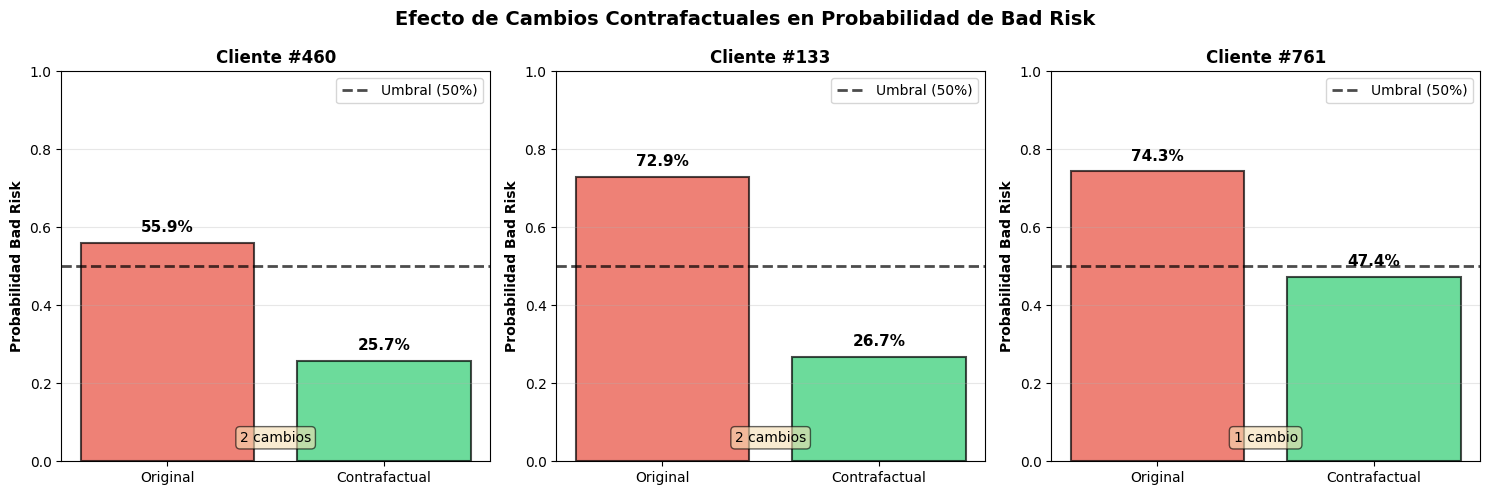

In [32]:
# ============================================================
# 7. VISUALIZACIÓN DE CONTRAFACTUALES (CORREGIDA)
# ============================================================
print("\n" + "="*60)
print("📊 VISUALIZACIÓN DE CONTRAFACTUALES")
print("="*60)

fig, axes = plt.subplots(1, len(counterfactuals), figsize=(15, 5))
fig.suptitle('Efecto de Cambios Contrafactuales en Probabilidad de Bad Risk', 
             fontsize=14, fontweight='bold')

if len(counterfactuals) == 1:
    axes = [axes]

for idx, (ax, cf) in enumerate(zip(axes, counterfactuals)):
    # Datos
    categories = ['Original', 'Contrafactual']
    probas = [cf['proba_original'], cf['proba_counterfactual']]
    
    # Colores: rojo si >50%, verde si <=50%
    colors = ['#e74c3c' if p > 0.5 else '#2ecc71' for p in probas]
    
    # ⚠️ VALIDACIÓN: Si no hubo cambio real, ambas barras iguales
    if abs(probas[0] - probas[1]) < 0.001:
        print(f"⚠️ Cliente #{study_cases[idx]}: Sin mejora real detectada")
    
    # Barras
    bars = ax.bar(categories, probas, color=colors, alpha=0.7, 
                   edgecolor='black', linewidth=1.5)
    
    # Línea umbral 50%
    ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2, 
               label='Umbral (50%)', alpha=0.7)
    
    # Configuración
    ax.set_ylabel('Probabilidad Bad Risk', fontweight='bold')
    ax.set_title(f'Cliente #{study_cases[idx]}', fontweight='bold')
    ax.set_ylim([0, 1])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Valores en barras
    for bar, val in zip(bars, probas):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.1%}', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)
    
    # Etiqueta de cambios
    if cf['num_changes'] > 0:
        label_text = f"{cf['num_changes']} cambio{'s' if cf['num_changes'] > 1 else ''}"
        if abs(probas[0] - probas[1]) < 0.001:
            label_text += " ⚠️ (sin efecto)"
    else:
        label_text = "0 cambios"
    
    ax.text(0.5, 0.05, label_text, 
            ha='center', transform=ax.transAxes, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))

plt.tight_layout()
plt.savefig('../models/counterfactual_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: ../models/counterfactual_comparison.png")
plt.show()

In [33]:
# ============================================================
# 8. RECOMENDACIONES ACCIONABLES
# ============================================================
print("\n" + "="*60)
print("💡 GENERACIÓN DE RECOMENDACIONES ACCIONABLES")
print("="*60)

def generate_recommendations(counterfactual_result, client_index, X, label_encoders):
    """
    Genera recomendaciones en lenguaje natural para el cliente.
    
    Parámetros:
    -----------
    counterfactual_result : dict
        Resultado del análisis contrafactual
    client_index : int
        Índice del cliente
    X : DataFrame
        Dataset original (sin encoding)
    label_encoders : dict
        Encoders para decodificar valores
    
    Retorna:
    --------
    str : Texto con recomendaciones personalizadas
    """
    
    changes = counterfactual_result['changes']
    proba_original = counterfactual_result['proba_original']
    proba_counterfactual = counterfactual_result['proba_counterfactual']
    
    # Encabezado
    recommendations = f"\n{'='*60}\n"
    recommendations += f"📋 RECOMENDACIONES PARA CLIENTE #{client_index}\n"
    recommendations += f"{'='*60}\n\n"
    
    recommendations += f"📊 Su solicitud actual tiene un riesgo de {proba_original:.0%}.\n"
    recommendations += f"   Para mejorar sus posibilidades de aprobación, sugerimos:\n\n"
    
    # Recomendaciones específicas
    if len(changes) == 0:
        recommendations += "⚠️ Lamentablemente, no hay cambios simples que mejoren\n"
        recommendations += "   significativamente su solicitud en este momento.\n"
        recommendations += "   Recomendamos:\n"
        recommendations += "   • Construir historial crediticio por 6-12 meses\n"
        recommendations += "   • Aumentar sus ahorros\n"
        recommendations += "   • Considerar un co-deudor\n"
    else:
        for i, change in enumerate(changes, 1):
            feature = change['feature']
            
            # Decodificar valores
            if feature in categorical_features:
                le = label_encoders[feature]
                orig_val = le.inverse_transform([int(change['original'])])[0]
                counter_val = le.inverse_transform([int(change['counterfactual'])])[0]
            else:
                orig_val = change['original']
                counter_val = change['counterfactual']
            
            # Generar recomendación según feature
            recommendations += f"{i}. "
            
            if feature == 'savings_status':
                recommendations += f"💰 Aumentar sus ahorros de '{orig_val}' a '{counter_val}'\n"
                recommendations += f"   Impacto: Mejora del {change['delta_proba']:.0%}\n\n"
            
            elif feature == 'employment':
                recommendations += f"💼 Mejorar situación laboral de '{orig_val}' a '{counter_val}'\n"
                recommendations += f"   Impacto: Mejora del {change['delta_proba']:.0%}\n\n"
            
            elif feature == 'duration':
                recommendations += f"⏰ Ajustar plazo del crédito de {orig_val} a {counter_val} meses\n"
                recommendations += f"   Impacto: Mejora del {change['delta_proba']:.0%}\n\n"
            
            elif feature == 'credit_amount':
                recommendations += f"💵 Reducir monto solicitado de ${orig_val:,} a ${counter_val:,}\n"
                recommendations += f"   Impacto: Mejora del {change['delta_proba']:.0%}\n\n"
            
            elif feature == 'property_magnitude':
                recommendations += f"🏠 Mejorar su situación de propiedad de '{orig_val}' a '{counter_val}'\n"
                recommendations += f"   Impacto: Mejora del {change['delta_proba']:.0%}\n\n"
            
            else:
                recommendations += f"📌 Cambiar '{feature}' de {orig_val} a {counter_val}\n"
                recommendations += f"   Impacto: Mejora del {change['delta_proba']:.0%}\n\n"
        
        # Resultado esperado
        recommendations += f"\n✅ Con estos cambios, su riesgo bajaría a {proba_counterfactual:.0%}\n"
        
        if proba_counterfactual < 0.5:
            recommendations += "   ¡Su solicitud sería APROBADA! ✅\n"
        else:
            recommendations += "   Su solicitud aún sería rechazada, pero mejoraría.\n"
            recommendations += "   Considere combinar estos cambios con otros factores.\n"
    
    recommendations += f"\n{'='*60}\n"
    
    return recommendations

# Generar recomendaciones para cada caso
print("\n🎯 RECOMENDACIONES PERSONALIZADAS:")

for i, (case_idx, cf) in enumerate(zip(study_cases, counterfactuals), 1):
    recommendations = generate_recommendations(cf, case_idx, X, label_encoders)
    print(recommendations)
    
    # Guardar en archivo
    with open(f'../models/recommendations_client_{case_idx}.txt', 'w', encoding='utf-8') as f:
        f.write(recommendations)
    
    print(f"✅ Recomendaciones guardadas: ../models/recommendations_client_{case_idx}.txt")



💡 GENERACIÓN DE RECOMENDACIONES ACCIONABLES

🎯 RECOMENDACIONES PERSONALIZADAS:

📋 RECOMENDACIONES PARA CLIENTE #460

📊 Su solicitud actual tiene un riesgo de 56%.
   Para mejorar sus posibilidades de aprobación, sugerimos:

1. 🏠 Mejorar su situación de propiedad de 'A122' a 'A121'
   Impacto: Mejora del 2%

2. ⏰ Ajustar plazo del crédito de 36 a 12 meses
   Impacto: Mejora del 29%


✅ Con estos cambios, su riesgo bajaría a 26%
   ¡Su solicitud sería APROBADA! ✅


✅ Recomendaciones guardadas: ../models/recommendations_client_460.txt

📋 RECOMENDACIONES PARA CLIENTE #133

📊 Su solicitud actual tiene un riesgo de 73%.
   Para mejorar sus posibilidades de aprobación, sugerimos:

1. 🏠 Mejorar su situación de propiedad de 'A124' a 'A121'
   Impacto: Mejora del 12%

2. 📌 Cambiar 'other_payment_plans' de A141 a A143
   Impacto: Mejora del 35%


✅ Con estos cambios, su riesgo bajaría a 27%
   ¡Su solicitud sería APROBADA! ✅


✅ Recomendaciones guardadas: ../models/recommendations_client_133.txt

In [34]:
# ============================================================
# 9. RESUMEN Y CONCLUSIONES
# ============================================================
print("\n" + "="*60)
print("📝 RESUMEN DE COUNTERFACTUAL EXPLANATIONS")
print("="*60)

print(f"\n📊 Estadísticas generales:")
print(f"   - Casos analizados: {len(counterfactuals)}")
print(f"   - Promedio de cambios sugeridos: {np.mean([cf['num_changes'] for cf in counterfactuals]):.1f}")
print(f"   - Casos con aprobación lograda: {sum([cf['approved'] for cf in counterfactuals])}/{len(counterfactuals)}")
print(f"   - Mejora promedio en riesgo: {np.mean([cf['proba_original'] - cf['proba_counterfactual'] for cf in counterfactuals]):.1%}")

if len(all_changes) > 0:
    print(f"\n🔝 Features más importantes para mejorar:")
    for i, (feat, count) in enumerate(change_frequency.head(3).items(), 1):
        print(f"   {i}. {feat} ({count} veces)")

print(f"\n💡 Insights clave:")
print("   ✅ Counterfactuals proveen explicaciones accionables")
print("   ✅ Permiten personalizar recomendaciones por cliente")
print("   ✅ Útiles para transparencia y cumplimiento regulatorio")
print("   ✅ Ayudan a clientes a entender cómo mejorar su perfil")

print(f"\n⚠️ Limitaciones:")
print("   - Solo consideran cambios en features individuales")
print("   - No validan si los cambios son realistas para el cliente")
print("   - Asumen que el modelo es correcto")

print("\n✅ Análisis de Counterfactual Explanations completado")
print("="*60)



📝 RESUMEN DE COUNTERFACTUAL EXPLANATIONS

📊 Estadísticas generales:
   - Casos analizados: 3
   - Promedio de cambios sugeridos: 1.7
   - Casos con aprobación lograda: 3/3
   - Mejora promedio en riesgo: 34.5%

🔝 Features más importantes para mejorar:
   1. property_magnitude (2 veces)
   2. duration (2 veces)
   3. other_payment_plans (1 veces)

💡 Insights clave:
   ✅ Counterfactuals proveen explicaciones accionables
   ✅ Permiten personalizar recomendaciones por cliente
   ✅ Útiles para transparencia y cumplimiento regulatorio
   ✅ Ayudan a clientes a entender cómo mejorar su perfil

⚠️ Limitaciones:
   - Solo consideran cambios en features individuales
   - No validan si los cambios son realistas para el cliente
   - Asumen que el modelo es correcto

✅ Análisis de Counterfactual Explanations completado


In [ ]:
# ============================================================
# 10. GUARDAR RESULTADOS
# ============================================================
print("\n" + "="*60)
print("💾 GUARDANDO RESULTADOS")
print("="*60)

# Guardar resultados en formato estructurado
results_df = pd.DataFrame([
    {
        'client_id': case_idx,
        'proba_original': cf['proba_original'],
        'proba_counterfactual': cf['proba_counterfactual'],
        'num_changes': cf['num_changes'],
        'approved': cf['approved'],
        'improvement': cf['proba_original'] - cf['proba_counterfactual']
    }
    for case_idx, cf in zip(study_cases, counterfactuals)
])

results_df.to_csv('../models/counterfactual_results.csv', index=False)
print("✅ Resultados guardados: ../models/counterfactual_results.csv")

# Guardar análisis completo
import pickle
with open('../models/counterfactual_analysis.pkl', 'wb') as f:
    pickle.dump({
        'counterfactuals': counterfactuals,
        'study_cases': study_cases,
        'change_frequency': change_frequency.to_dict() if len(all_changes) > 0 else {}
    }, f)
print("✅ Análisis completo guardado: ../models/counterfactual_analysis.pkl")

print("\n✅ Notebook completado exitosamente")